<a href="https://colab.research.google.com/github/Harold-Rodriguez/ECG/blob/main/Project_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Nov 26 14:53:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import h5py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path_data = '/content/drive/MyDrive/11_MAS2/ECG/data'

y = pd.read_csv(f'{path_data}/annotations/gold_standard.csv')

with h5py.File(f"{path_data}/ecg_tracings.hdf5", "r") as f:
  x = np.array(f['tracings'])
#print(y) 

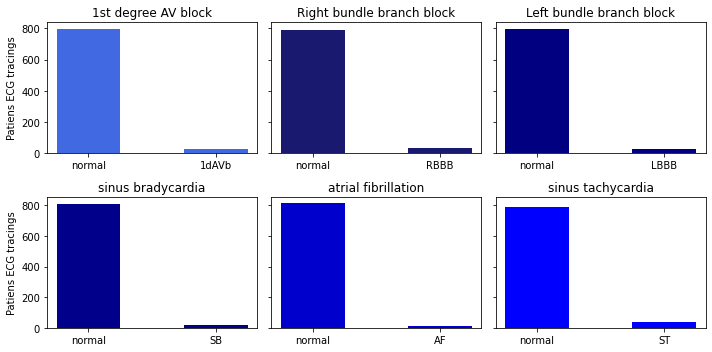

In [4]:
n_bins = 200
labels= ['normal']
labels.extend(y.columns)
label = 3
axes=np.array([2, 3])
colors=['royalblue', 'midnightblue', 'navy', 'darkblue', 'mediumblue', 'blue']
titles = ['1st degree AV block', 'Right bundle branch block', 'Left bundle branch block', 'sinus bradycardia', 'atrial fibrillation', 'sinus tachycardia']
fig, axs = plt.subplots(2, 3, figsize=(10,5), tight_layout=True, sharey='row')
axs[0, 0].set_ylabel('Patiens ECG tracings')
axs[1, 0].set_ylabel('Patiens ECG tracings') 
for i in range(axes[0]) :
  label*=i
  for n in range(axes[1]):
    axs[i, n].bar((labels[0], labels[label+1]), y[labels[label+1]].value_counts(), width=0.5, color = colors[label])
    axs[i, n].set_title(titles[label])
    label+=1

In [5]:
x_flatten=x.reshape(827,12*4096)
X_Train, X_Test, Y_Train, Y_Test = train_test_split(x_flatten, y["1dAVb"], test_size=0.20, random_state=1) 

In [6]:
N = 49152
f_s = 200
t_n = 2.56
T = t_n / N
amplitudes = X_Train
x_value = np.linspace(0,t_n,N)
frequencies = [17, 15.5, 14, 12.5, 11, 9.5, 8, 6.5, 5, 3, 1.5, 1]
frequencies = np.tile(frequencies, len(amplitudes))
y_values = [amplitudes[ii]*np.sin(2*np.pi*frequencies[ii]*x_value) for ii in range(0,len(amplitudes))]
composite_y_value = np.sum(y_values, axis=0)